# Loading Modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from POLO.PYramid2 import cropped_pyramid, local_filter, get_K, log_gabor_transform
from POLO.PYramid2 import inverse_pyramid, get_K_inv, inverse_gabor
from utils import view_data
from typing import List, Tuple
from easydict import EasyDict as edict
import pickle

Default lg shape= 32 32


In [2]:
#args.offset_std = 30
#args.contrast = 0.7

width = {'in': 32, 'out': 64, 'ext': 128}

n_levels = {'in': 3, 'out': 3, 'ext': 3} 

base_levels = 2

n_color = {'in': 3, 'out': 3, 'ext': 3}

color = True

color_mode= 'rgb' #'lab' # 'hsv' #True

r_min = {'in': width['in'] / 4, 'out': width['out'] / 4, 'ext': width['ext'] / 4}

r_max = {'in': width['in'] / 2, 'out': width['out'] / 2, 'ext': width['ext'] / 2}

n_sublevel = n_eccentricity = {'in': 2, 'out': 4, 'ext': 8}

n_azimuth = {'in': 16, 'out': 32, 'ext': 64}

n_theta = {'in': 8, 'out': 8, 'ext': 8}

n_phase = {'in': 1, 'out': 1, 'ext': 1}

do_mask = False

gauss = False






In [3]:
lg={}
for k in ['in', 'out', 'ext']:
    pe = {'N_X': width[k], 'N_Y': width[k], 'do_mask': do_mask, 'base_levels':
              base_levels, 'n_theta': 0, 'B_sf': np.inf, 'B_theta': np.inf ,
          'use_cache': True, 'figpath': 'results', 'edgefigpath':
              'results/edges', 'matpath': 'cache_dir', 'edgematpath':
              'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
              14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

    lg[k] = LogGabor(pe)

In [4]:
K = {}
for k in ['in', 'out', 'ext']:
    K[k] = get_K(width=width[k],
          n_sublevel = n_sublevel[k], 
          n_azimuth = n_azimuth[k], 
          n_theta = n_theta[k],
          n_phase = n_phase[k], 
          r_min = r_min[k], 
          r_max = r_max[k], 
          log_density_ratio = 2, 
          verbose=True,
          lg=lg[k])

i_sublevel, sf_0, radius 0 0.36067376022224085 8.0
i_sublevel, sf_0, radius 1 0.25503486164919736 11.31370849898476
K shape= torch.Size([32, 32, 2, 16, 8, 1])
K min max= tensor(-0.2794) tensor(1.)
i_sublevel, sf_0, radius 0 0.18033688011112042 16.0
i_sublevel, sf_0, radius 1 0.15164463602348005 19.027313840043536
i_sublevel, sf_0, radius 2 0.12751743082459868 22.62741699796952
i_sublevel, sf_0, radius 3 0.10722895046276856 26.908685288118864
K shape= torch.Size([64, 64, 4, 32, 8, 1])
K min max= tensor(-0.2555) tensor(1.)
i_sublevel, sf_0, radius 0 0.09016844005556021 32.0
i_sublevel, sf_0, radius 1 0.08268482410040677 34.89624744528824
i_sublevel, sf_0, radius 2 0.07582231801174003 38.05462768008707
i_sublevel, sf_0, radius 3 0.06952937218191597 41.49886574883231
i_sublevel, sf_0, radius 4 0.06375871541229934 45.25483399593904
i_sublevel, sf_0, radius 5 0.05846699982261448 49.35074641305411
i_sublevel, sf_0, radius 6 0.05361447523138428 53.81737057623773
i_sublevel, sf_0, radius 7 0.04

In [5]:
K_inv={}
for k in ['in', 'out', 'ext']:
    K_inv[k] = get_K_inv(K[k], 
                  width=width[k], 
                  n_sublevel = n_sublevel[k], 
                  n_azimuth = n_azimuth[k], 
                  n_theta = n_theta[k], 
                  n_phase = n_phase[k])

Filter tensor shape= torch.Size([32, 32, 2, 16, 8, 1])
Reshaped filter tensor= torch.Size([1024, 256])
Tensor shape= torch.Size([256, 1024])
Filter tensor shape= torch.Size([64, 64, 4, 32, 8, 1])
Reshaped filter tensor= torch.Size([4096, 1024])
Tensor shape= torch.Size([1024, 4096])
Filter tensor shape= torch.Size([128, 128, 8, 64, 8, 1])
Reshaped filter tensor= torch.Size([16384, 4096])
Tensor shape= torch.Size([4096, 16384])


# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [6]:
args = init(filename='2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

In [62]:
args.batch_size

50

In [7]:
class DualCroppedPyramid(object):
    def __init__(self, width, 
                 base_levels, 
                 color=color, 
                 do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode

    def __call__(self, img):
        img_crop = {}
        for k in ['in', 'out', 'ext']:
            img_crop_part, level_size = cropped_pyramid(img.unsqueeze(0), 
                                               width=self.width[k], 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True,
                                               gauss=gauss,
                                               n_levels=self.n_levels[k],
                                               color_mode=self.color_mode)
            #print(img_crop_part.shape)
            img_crop[k] = img_crop_part[:self.n_levels[k]-1,...]
        return img, img_crop   

### LogGaborTransform

In [8]:
class DualLogGaborTransform(object):
    def __init__(self, K=K, color=color, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose

    def __call__(self, cropped_pyr):
        img = cropped_pyr[0]
        img_crop = cropped_pyr[1]
        log_gabor_coeffs = {}
        for k in ['in', 'out', 'ext']:
            log_gabor_coeffs[k] = log_gabor_transform(img_crop[k].unsqueeze(1), K[k], color=self.color).squeeze(1)
        
        return img, log_gabor_coeffs

In [9]:
class DualLogGaborReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose

    def __call__(self, log_gabor_transform):
        img = log_gabor_transform[0]
        log_gabor_coeffs = log_gabor_transform[1]
        for k in ['in', 'out', 'ext']:
            # n_batch, n_levels, n_color, n_sublevel, n_azimuth, n_theta, n_phase
            # x      , 0       , 1      , 2         , 3        , 4      , 5
            # 
            #print(log_gabor_coeffs[k].shape)
            log_gabor_coeffs[k] = log_gabor_coeffs[k].permute(1, 4, 5, 0, 2, 3).contiguous()
            log_gabor_coeffs[k] = log_gabor_coeffs[k].view(self.n_color[k]*self.n_theta[k]*self.n_phase[k], 
                                                     (self.n_levels[k]-1) * self.n_eccentricity[k], 
                                                     self.n_azimuth[k])
 
        return img, log_gabor_coeffs

In [10]:
class LogGaborInvReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):

        if self.verbose:
            print('log_gabor_coeffs.shape:', log_gabor_coeffs.shape)
        log_gabor_coeffs = log_gabor_coeffs.view(-1, 
                                                 self.n_color, 
                                                 self.n_theta, 
                                                 self.n_phase, 
                                                 self.n_levels-1, 
                                                 self.n_eccentricity, 
                                                 self.n_azimuth)
        log_gabor_coeffs = log_gabor_coeffs.permute(0, 4, 1, 5, 6, 2, 3).contiguous()
        return log_gabor_coeffs

In [11]:
class LogGaborInvTransform(object):
    def __init__(self, K_inv=K_inv, color=color, verbose=False):
        self.K_inv = K_inv
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):
        log_gabor_coeffs = torch.cat((log_gabor_coeffs,torch.zeros_like(log_gabor_coeffs[:,:1,...])), dim=1) 
        img_crop=inverse_gabor(log_gabor_coeffs.detach(), self.K_inv, self.verbose)
        if self.verbose:
            print('img_crop.shape:', img_crop.shape)

        return img_crop

In [12]:
class InvCroppedPyramid(object):
    def __init__(self, 
                 #width, 
                 base_levels, 
                 color=color, 
                 #do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb',
                 N_X = 256,
                 N_Y = 256):
        #self.width = width
        self.base_levels = base_levels
        self.color = color
        #self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode
        self.N_X = N_X
        self.N_Y = N_Y

    def __call__(self, img_crop):
        #print('img_crop.shape:', img_crop.shape)
        full_img_rec = inverse_pyramid(img_crop, 
                                       N_X = self.N_X,
                                       N_Y = self.N_Y,
                                       #width=self.width, 
                                       base_levels=self.base_levels,
                                       color=self.color, 
                                       #do_mask=self.do_mask, 
                                       verbose=self.verbose,
                                       #squeeze=True,
                                       gauss=gauss,
                                       n_levels=self.n_levels) #,
                                       #color_mode=self.color_mode)
        return full_img_rec

### Inverse transformations (for display only)

# Exploring the MNIST with where noise parameters and log polar encoding

- 128x128 pixel with shift, noise and circular mask

In [13]:
#args.offset_max = 40 #like in the paper

In [14]:
# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
v_mean = np.array([0.485, 0.456, 0.406])
v_std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=v_mean, std=v_std) # to normalize colors on the imagenet dataset



In [15]:
image_size = 256

vgg_transform =  transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            #transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm, 
        ])

polo_transform =  transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            #transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            #transforms_norm, 
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

transform_big =  transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            #transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

In [16]:
width,base_levels, color, n_levels

({'in': 32, 'out': 64, 'ext': 128}, 2, True, {'in': 3, 'out': 3, 'ext': 3})

In [18]:
#image_path = "../data/animal/"
#image_path = "/media/manu/Seagate Expansion Drive/Data/animal/"
image_path = "/home/INT/dauce.e/data/Imagenet_full/"

vgg_image_dataset = { 'train' : datasets.ImageFolder(
                            image_path+'train', 
                            transform=vgg_transform
                        ),
                  'test' : datasets.ImageFolder(
                            image_path+'val', 
                            transform=vgg_transform
                        )
                }

In [19]:
polo_image_dataset = { 'train' : datasets.ImageFolder(
                            image_path+'train', 
                            transform=polo_transform
                        ),
                  'test' : datasets.ImageFolder(
                            image_path+'val', 
                            transform=polo_transform
                        )
                }

In [20]:
dataset_size = {'train' : len(vgg_image_dataset['train']),
                'test' : len(vgg_image_dataset['test'])}

dataset_size['train'], dataset_size['test']

(1281168, 50001)

In [21]:
args.batch_size = 50
num_workers = 1

vgg_dataloader = { 'train' : torch.utils.data.DataLoader(
                            vgg_image_dataset['train'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        ),
               'test' : torch.utils.data.DataLoader(
                            vgg_image_dataset['test'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }

In [22]:
polo_dataloader = { 'train' : torch.utils.data.DataLoader(
                            polo_image_dataset['train'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        ),
               'test' : torch.utils.data.DataLoader(
                            polo_image_dataset['test'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }

In [23]:
data, label = next(iter(polo_dataloader['train']))

In [27]:
data_original = data[0]
data_polo = data[1]
data_original.shape, data_polo['in'].shape, data_polo['out'].shape, data_polo['ext'].shape

(torch.Size([50, 3, 256, 256]),
 torch.Size([50, 24, 4, 16]),
 torch.Size([50, 24, 8, 32]),
 torch.Size([50, 24, 16, 64]))

In [29]:
img_size = np.prod(data_original.shape)//args.batch_size
print('original image size:', img_size)

polo_size = {}
for k in ('in', 'out', 'ext'):
    polo_size[k] = np.prod(data_polo[k].shape) //args.batch_size
    print(k, ':', polo_size[k])
total_polo_size = polo_size['in'] + polo_size['out'] + polo_size['ext']

print('total polo size:', total_polo_size) 
print(f'compression rate : {100 * (1 - total_polo_size/img_size):.2f} %')

original image size: 196608
in : 1536
out : 6144
ext : 24576
total polo size: 32256
compression rate : 83.59 %


In [30]:
n_levels, n_color, n_sublevel, n_azimuth, n_theta, n_phase

({'in': 3, 'out': 3, 'ext': 3},
 {'in': 3, 'out': 3, 'ext': 3},
 {'in': 2, 'out': 4, 'ext': 8},
 {'in': 16, 'out': 32, 'ext': 64},
 {'in': 8, 'out': 8, 'ext': 8},
 {'in': 1, 'out': 1, 'ext': 1})

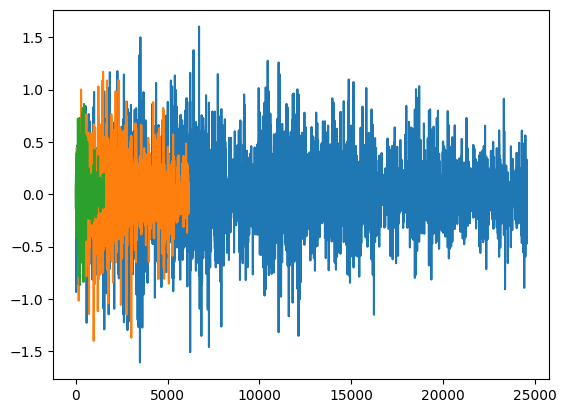

In [31]:
plt.plot(data_polo['ext'][3,...].detach().numpy().flatten())
plt.plot(data_polo['out'][3,...].detach().numpy().flatten())
plt.plot(data_polo['in'][3,...].detach().numpy().flatten())



### Displaying Log Gabor Encoded visual field using pseudo-inverse transformation

In [32]:
inverse_transform = {}
verbose = True
for k in ['in', 'out', 'ext']:
    N_X = N_Y = width[k] * 2**(n_levels[k]-1)
    print(N_X)
    inverse_transform[k] = transforms.Compose([
        LogGaborInvReshape(n_levels[k], n_color[k], n_eccentricity[k], n_azimuth[k], n_theta[k], n_phase[k], color=color, verbose=verbose),        
        LogGaborInvTransform(K_inv=K_inv[k], color=color, verbose=verbose),
        InvCroppedPyramid(base_levels, n_levels=n_levels[k], verbose=verbose, N_X=N_X, N_Y=N_Y),
    ])

128
256
512


In [33]:
def img_denorm(img, mean, std):
    #for ImageNet the mean and std are:
    #mean = np.asarray([ 0.485, 0.456, 0.406 ])
    #std = np.asarray([ 0.229, 0.224, 0.225 ])

    denormalize = transforms.Normalize((-1 * mean / std), (1.0 / std))

    res = img.squeeze(0)
    res = denormalize(res)

    #Image needs to be clipped since the denormalize function will map some
    #values below 0 and above 1
    res = torch.clamp(res, 0, 1)
    
    return(res)

- The Log-Polar compressed format

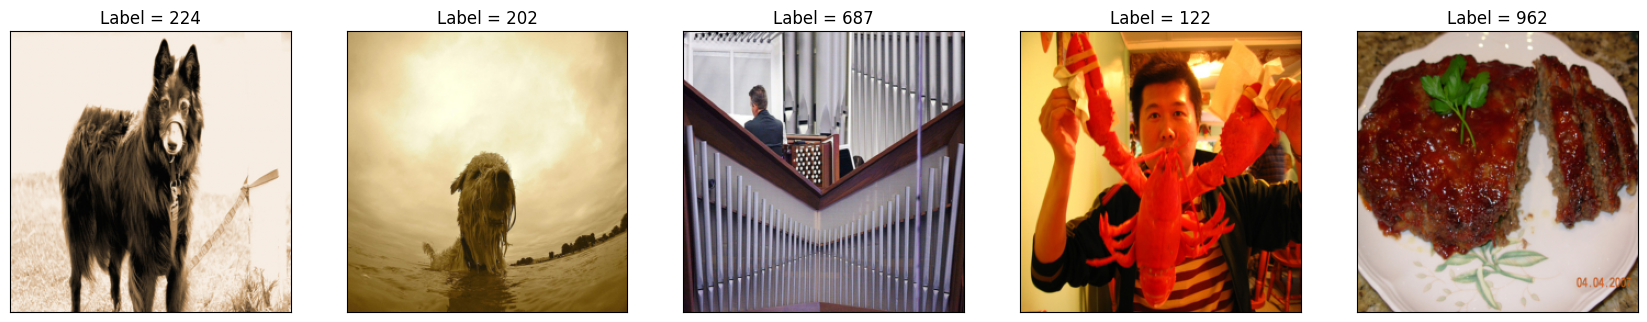

In [34]:

#for i in range(len(data_original)):
#    data_original[i] = img_denorm(data_original[i], v_mean, v_std)
original = view_data(data_original, label, 5)

In [35]:
inverse_transform['ext']

Compose(
)

log_gabor_coeffs.shape: torch.Size([50, 24, 4, 16])
Tensor shape= torch.Size([2, 16, 8, 1, 32, 32])
img_crop.shape: torch.Size([50, 3, 3, 32, 32])
log_gabor_coeffs.shape: torch.Size([50, 24, 8, 32])
Tensor shape= torch.Size([4, 32, 8, 1, 64, 64])
img_crop.shape: torch.Size([50, 3, 3, 64, 64])
log_gabor_coeffs.shape: torch.Size([50, 24, 16, 64])
Tensor shape= torch.Size([8, 64, 8, 1, 128, 128])
img_crop.shape: torch.Size([50, 3, 3, 128, 128])


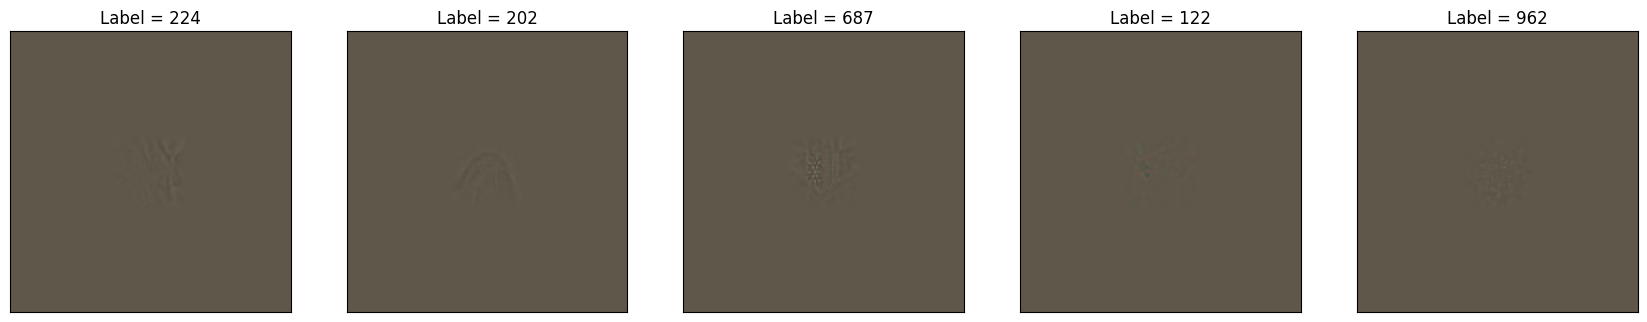

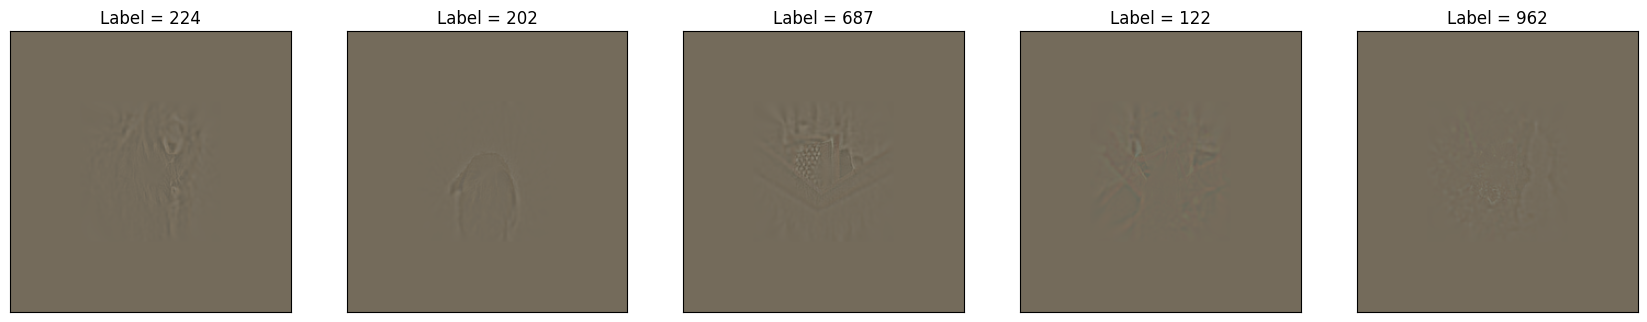

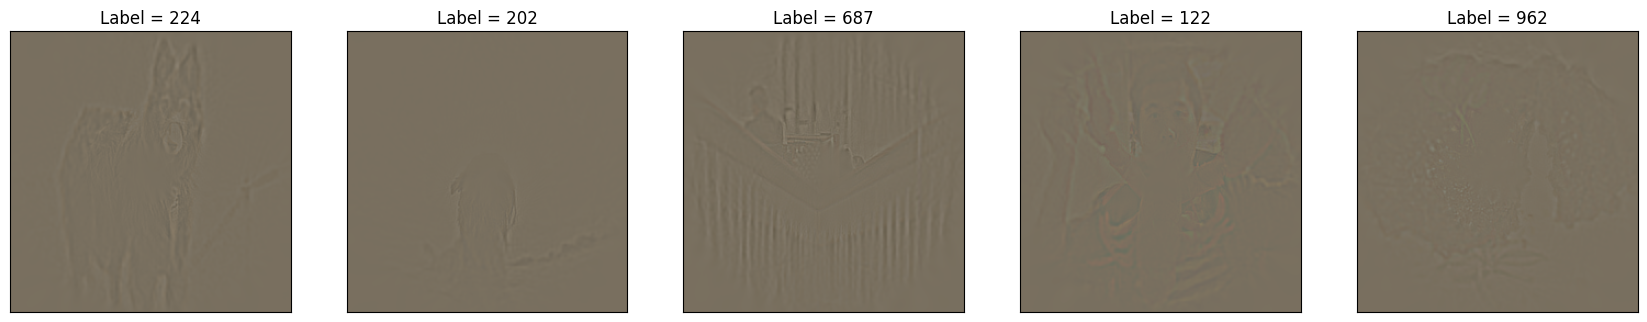

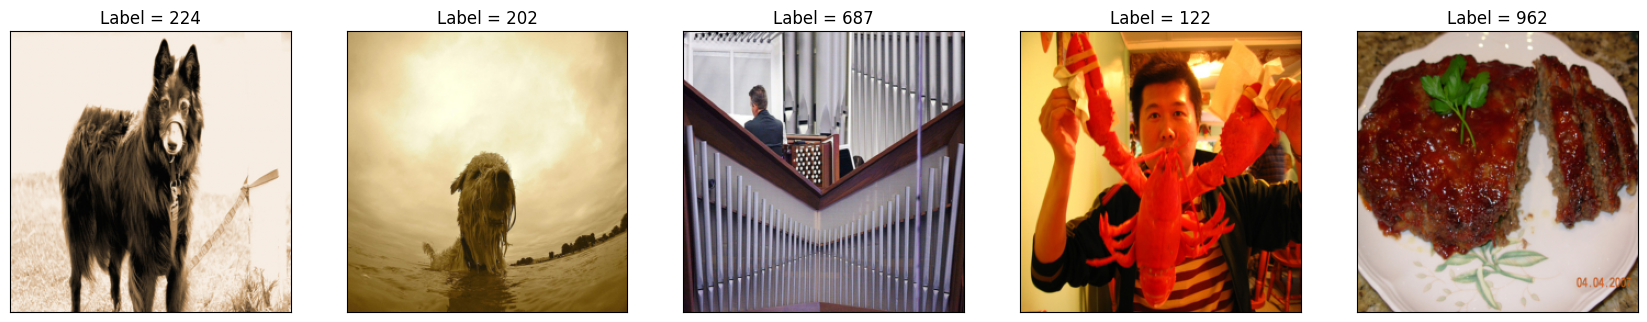

In [36]:
b = {'in':32,'out':64, 'ext': 128}
img_sum = torch.zeros(args.batch_size, 3, 256, 256)
for k in ['in', 'out', 'ext']:
    data = data_polo[k] #
    #data = torch.cat((data_polo[k],torch.zeros_like(data_polo[k][:,:1,...])), dim=1) 
    full_img_rec = inverse_transform[k](data)
    img_aff = full_img_rec[:,:,b[k]:-b[k],b[k]:-b[k]]    
    if k == 'ext':
        img_sum += img_aff
    else:
        img_sum[:,:,128-b[k]:128+b[k],128-b[k]:128+b[k]]  += img_aff

    for i in range(len(data_original)):
        img_sum[i] = img_denorm(img_sum[i]-0.5
                                , v_mean, v_std)
    _ = view_data(img_sum, label, 5)
_ = view_data(data_original, label, 5)

- The original format

In [37]:
data_polo['in'].shape, data_polo['out'].shape, data_polo['ext'].shape

(torch.Size([50, 24, 4, 16]),
 torch.Size([50, 24, 8, 32]),
 torch.Size([50, 24, 16, 64]))

# Creating an Attention Transformer model with log-polar entry (POLO-STN)

In [38]:
transform_in =  transforms.Compose([
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

In [39]:
def negentropy_loss(model, z):
    z_mean = torch.mean(z, dim=0)
    z_std = torch.std(z, dim=0)
    p = torch.distributions.Normal(torch.ones_like(z)*z_mean, torch.ones_like(z) * z_std)
    return model.LAMBDA * p.log_prob(z).sum()

In [40]:
def kl_divergence(model, z):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    z_dims = z.size()
    if args.radius > 0:
        #p = torch.distributions.Normal(torch.zeros_like(z), args.radius * torch.ones_like(z))
        p = torch.distributions.MultivariateNormal(torch.zeros_like(z), 
                                                   args.radius * torch.einsum('i,jk->ijk',torch.ones(z_dims[0]), torch.eye(2)))
    else:
        p = torch.distributions.Normal(torch.zeros_like(z), 1e-6 * torch.ones_like(z))


    # 2. get the probabilities from the equation
    #log_qzx = model.q.log_prob(z)
    log_pz = p.log_prob(z)

    z_mean = torch.mean(z, dim=0)
    z_std = torch.std(z, dim=0) + 1e-6
    #print(z)
    #print(torch.cov(z.T))
    #print(torch.eye(2))
    z_cov = torch.cov(z.T) + 1e-6 * torch.eye(2).to(device)
    #print(z_std)
    #q = torch.distributions.MultivariateNormal(torch.ones_like(z)*z_mean, torch.ones_like(z) * z_std)
    q = torch.distributions.MultivariateNormal(torch.ones_like(z)*z_mean, torch.ones(z_dims[0], 2, 2).to(device) * z_cov)
    log_qzx = q.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    
    # sum over last dim to go from single dim distribution to multi-dim
    kl = kl.sum()
    return kl

In [41]:
class Polo_AttentionTransNet(nn.Module):
    
    def __init__(self, do_stn=True, do_what=False, deterministic=False, LAMBDA=.1):
        super(Polo_AttentionTransNet, self).__init__()
        
        self.do_stn = do_stn
        self.do_what = do_what
        self.deterministic = deterministic
        
        self.LAMBDA = LAMBDA

        ##  The what pathway
        self.wloc0 = nn.Conv2d(n_color['ext'] * n_theta['ext'] * n_phase['ext'], 
                              50, 3, padding=1)
        self.wloc1a = nn.Conv2d(50, 100, 3, padding=1)
        self.wloc1b = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
                              100, 3, padding=1)
        self.wloc2a = nn.Conv2d(100, 200, 3, padding=1)
        self.wloc2b = nn.Conv2d(100, 200, 3, padding=1)
        self.wloc2c = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
                               200, 3, padding=1)
        self.wloc3 = nn.Conv2d(200, 500, 3, padding=1)
        self.wloc4 = nn.Conv2d(500, 1000, 3, padding=1)
        self.wloc5_short = nn.Linear(1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8), 1000, bias=False)
        self.wloc5 = nn.Linear(1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8), 1000)
        self.wloc6 = nn.Linear(1000, 1000, bias=False)

        #self.wloc4.weight.data.zero_()
        #self.wloc4.bias.data.zero_()

                
        ##  The where pathway        
        self.loc_ext_1 = nn.Conv2d(n_color['ext'] * n_theta['ext'] * n_phase['ext'], 
                              128, 3, padding=1, stride=1)
        self.loc_ext_2 = nn.Conv2d(32, 128, 5, padding=2, stride=1)
        self.loc_ext_3 = nn.Conv2d(32, 128, 7, padding=3, stride=1)

        self.loc_out_1 = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
                              128, 3, padding=1, stride=1)
        self.loc_out_2 = nn.Conv2d(32, 128, 5, padding=2,stride=1)

        self.loc_in_1 = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
                              128, 3, padding=1, stride=1)
        self.loc_in_2 = nn.Conv2d(32, 128, 5, padding=2,stride=1)

        self.upsample_in = nn.ConvTranspose2d(32, 32, 3, padding=1, stride=2)       
        self.loc_in_out = nn.Conv2d(32, 128, 7, padding=3,stride=1)

        self.upsample_out = nn.ConvTranspose2d(32, 32, 3, padding=1, stride=2)   
        self.loc_all = nn.Conv2d(32, 128, 9, padding=4,stride=1)

        final_dim = 3 * (n_levels['ext']-1) * n_eccentricity['ext'] * n_azimuth['ext']
        self.fc_where = nn.Linear(final_dim * 32, final_dim)
        self.mu = nn.Linear(final_dim, 2, bias=False)
        self.logvar = nn.Linear(final_dim, 2, bias=False)
        
        #self.loc4.weight.data.zero_()
        #self.loc4.bias.data.zero_()

        self.downscale = nn.Parameter(torch.tensor([[1, 0], [0, 1]],
                                                   dtype=torch.float),
                                      requires_grad=False)

    def stn(self: object, x: torch.Tensor, x_polo: torch.Tensor) -> Tuple[torch.Tensor]:
    
        if self.do_stn:
            xs_part = {}
            #for k in ['in', 'out']:
            #    print(x_polo[k].shape)
            #    xs_part[k] = x_polo[k].permute(0,2,5,6,1,3,4)
            #    xs_part[k] = xs_part[k].view(-1, n_color[k] * n_theta[k] * n_phase[k], 
            #                                 (n_levels[k]-1) * n_eccentricity[k], 
            #                                 n_azimuth[k])

            #print(x_polo['out'].shape)

            if True: #with torch.no_grad():

                c_in = 128
                c_out = 32

                # in
                w_in = (n_levels['in']-1) * n_eccentricity['in']
                h_in = n_azimuth['in']

                x_in = F.relu(self.loc_in_1(x_polo['in']))
                x_in = x_in.view(-1, c_in, w_in * h_in).permute(0, 2, 1)
                x_in = nn.MaxPool1d(4)(x_in)
                x_in = x_in.permute(0,2,1).view(-1, c_out, w_in, h_in)

                x_in = F.relu(self.loc_in_2(x_in))
                x_in = x_in.view(-1, c_in, w_in * h_in).permute(0, 2, 1)
                x_in = nn.MaxPool1d(4)(x_in)
                x_in = x_in.permute(0,2,1).view(-1, c_out, w_in, h_in)

                x_in = nn.Upsample(scale_factor=2, mode='nearest')(x_in)

                # out
                w_out = (n_levels['out']-1) * n_eccentricity['out']
                h_out = n_azimuth['out']

                x_out = F.relu(self.loc_out_1(x_polo['out']))
                x_out = x_out.view(-1, c_in, w_out * h_out).permute(0, 2, 1)
                x_out = nn.MaxPool1d(4)(x_out)
                x_out = x_out.permute(0,2,1).view(-1, c_out, w_out, h_out)

                x_out = F.relu(self.loc_out_2(x_out))
                x_out = x_out.view(-1, c_in, w_out * h_out).permute(0, 2, 1)
                x_out = nn.MaxPool1d(4)(x_out)
                x_out = x_out.permute(0,2,1).view(-1, c_out, w_out, h_out)

                x_in_out = torch.cat((x_in, x_out), dim=2)

                x_in_out = F.relu(self.loc_in_out(x_in_out))
                x_in_out = x_in_out.view(-1, c_in, 2 * w_out * h_out).permute(0, 2, 1)
                x_in_out = nn.MaxPool1d(4)(x_in_out)
                x_in_out = x_in_out.permute(0,2,1).view(-1, c_out, 2 * w_out, h_out)

                x_in_out = nn.Upsample(scale_factor=2, mode='nearest')(x_in_out)

                # ext
                w_ext = (n_levels['ext']-1) * n_eccentricity['ext']
                h_ext = n_azimuth['ext']

                x_ext = F.relu(self.loc_ext_1(x_polo['ext']))
                x_ext = x_ext.view(-1, c_in, w_ext * h_ext).permute(0, 2, 1)
                x_ext = nn.MaxPool1d(4)(x_ext)
                x_ext = x_ext.permute(0,2,1).view(-1, c_out, w_ext, h_ext)

                x_ext = F.relu(self.loc_ext_2(x_ext))
                x_ext = x_ext.view(-1, c_in, w_ext * h_ext).permute(0, 2, 1)
                x_ext = nn.MaxPool1d(4)(x_ext)
                x_ext = x_ext.permute(0,2,1).view(-1, c_out, w_ext, h_ext)

                x_ext = F.relu(self.loc_ext_3(x_ext))
                x_ext = x_ext.view(-1, c_in, w_ext * h_ext).permute(0, 2, 1)
                x_ext = nn.MaxPool1d(4)(x_ext)
                x_ext = x_ext.permute(0,2,1).view(-1, c_out, w_ext, h_ext)

                x_all = torch.cat((x_in_out, x_ext), dim=2)

                x_all = F.relu(self.loc_all(x_all))
                x_all = x_all.view(-1, c_in, 3 * w_ext * h_ext).permute(0, 2, 1)
                x_all = nn.MaxPool1d(4)(x_all)
                x_all = x_all.permute(0,2,1).view(-1, c_out * 3 * w_ext * h_ext)

                x_all = F.relu(self.fc_where(x_all))
              
            
            mu = self.mu(x_all)
            if self.deterministic:
                sigma = args.radius * torch.ones_like(mu)  
                self.q = torch.distributions.MultivariateNormal(mu, torch.diag_embed(sigma))
                z = mu
            else:
                logvar = self.logvar(x_all) + 5
                sigma = torch.exp(-logvar / 2)
                #print(sigma)
                print(mu.size(), sigma.size())
                self.q = torch.distributions.MultivariateNormal(mu, torch.diag_embed(sigma))      
                z = self.q.rsample()
            
            print(z[0,...])
            theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
            grid_size = torch.Size([x.size()[0], x.size()[1], 256, 256])
            grid = F.affine_grid(theta, grid_size)
            x = F.grid_sample(x, grid)

        else:
            mu = torch.tensor([0, 0],dtype=torch.double)
            mu = mu.unsqueeze(0).repeat(x.size()[0], 1)   
            sigma = torch.tensor([1, 1],dtype=torch.double)
            sigma = sigma.unsqueeze(0).repeat(x.size()[0], 1)    
            
            if self.do_what and args.radius > 0:
                self.q = torch.distributions.Normal(mu, args.radius*sigma)
                z = self.q.rsample().to(device)
                print(z[0,...])
                theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
                grid_size = torch.Size([x.size()[0], x.size()[1], 256, 256])
                grid = F.affine_grid(theta, grid_size)
                x = F.grid_sample(x, grid)
            else:
                z = torch.tensor([0, 0],dtype=torch.float)
                z = z.unsqueeze(0).repeat(x.size()[0], 1).to(device)

                theta = nn.Parameter(torch.tensor([[1, 0, 0], [0, 1, 0]],
                                                    dtype=torch.float),
                                        requires_grad=False)
                theta = theta.unsqueeze(0).repeat(x.size()[0], 1, 1)
            
              
        return x, theta, z

    def forward(self, x, x_polo, training_step = None):
        # transform the input
        x, theta, z = self.stn(x, x_polo)
        
        if self.do_stn or (self.do_what and args.radius > 0):
        
            w_x_polo ={'in': torch.zeros_like(x_polo['in']),
                       'out': torch.zeros_like(x_polo['out']),
                       'ext': torch.zeros_like(x_polo['ext'])}
            for i in range(args.batch_size):
                d, w = transform_in(x[i,...])
                w_x_polo['in'][i,...] = w['in']
                w_x_polo['out'][i,...] = w['out']
                w_x_polo['ext'][i,...] = w['ext']
        else:
            w_x_polo = x_polo
                                           

        # print(x.shape)
        # Perform the usual forward pass

        ya = F.relu(self.wloc0(w_x_polo['ext']))
        ya = nn.MaxPool2d(2)(ya)     
        ya = F.relu(self.wloc1a(ya))
        ya = nn.MaxPool2d(2)(ya)
        ya = F.relu(self.wloc2a(ya))
        ya = nn.MaxPool2d(2)(ya)


        yb = F.relu(self.wloc1b(w_x_polo['out']))
        yb = nn.MaxPool2d(2)(yb)        
        yb = F.relu(self.wloc2b(yb))
        yb = nn.MaxPool2d(2)(yb)
        
        yc = F.relu(self.wloc2c(w_x_polo['in']))
        yc = nn.MaxPool2d(2)(yc)

        y = torch.cat((ya, yb, yc), dim=2)
        y = F.relu(self.wloc3(y))
        y = nn.MaxPool2d(2)(y)
        y = F.relu(self.wloc4(y))
        y = nn.MaxPool2d((3,2))(y)

        #print(y.shape)
        #print(1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8))
        if training_step == 0:
            y = y.view(-1, 1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8))
            y = self.wloc5_short(y)
        else:
            y = F.relu(self.wloc5(y.view(-1, 1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8))))
            y = self.wloc6(y)

        return y, theta, z

In [43]:
lr = 1e-4
LAMBDA = 0.1
deterministic = True
do_stn = True
do_what = False
radius = 0.01
args.batch_size = 50
args.radius = 0.1

In [53]:
path = 'out/'
f_prefix = f"240110_polo_stn_dual_{LAMBDA}_0.01"
#f_prefix = "230222_polo_stn_dual_lambda_0.0001_0.2"


In [48]:
f"{path}{f_prefix}.pkl"

'out/240110_POLO_stn_dual_0.1_0.01.pkl'

In [47]:
with open(f"{path}{f_prefix}.pkl", "rb") as f:
    data = pickle.load(f)
data=edict(data)

FileNotFoundError: [Errno 2] No such file or directory: 'out/240110_POLO_stn_dual_0.1_0.01.pkl'

Text(0.5, 1.0, 'Entropy')

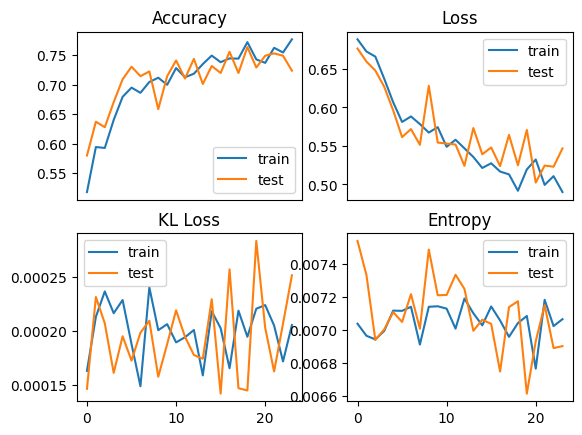

In [35]:
plt.subplot(2,2,1)
plt.plot(data.train_acc, label='train')
plt.plot(data.test_acc, label='test')
plt.legend()
plt.xticks([])
plt.title('Accuracy')
plt.subplot(2,2,2)
plt.plot(data.train_loss, label='train')
plt.plot(data.test_loss, label='test')
plt.legend()
plt.title('Loss')
plt.xticks([])
plt.subplot(2,2,3)
plt.plot(data.train_kl_loss, label='train')
plt.plot(data.test_kl_loss, label='test')
plt.legend()
plt.title('KL Loss')
plt.subplot(2,2,4)
plt.plot(data.train_entropy, label='train')
plt.plot(data.test_entropy, label='test')
plt.legend()
plt.title('Entropy')

Text(0.5, 1.0, 'Entropy')

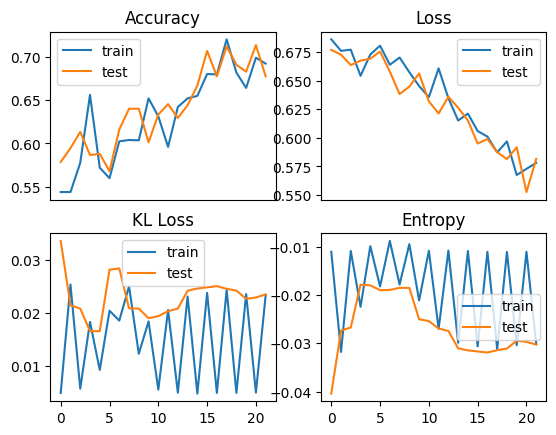

In [ ]:
plt.subplot(2,2,1)
plt.plot(data.train_acc, label='train')
plt.plot(data.test_acc, label='test')
plt.legend()
plt.xticks([])
plt.title('Accuracy')
plt.subplot(2,2,2)
plt.plot(data.train_loss, label='train')
plt.plot(data.test_loss, label='test')
plt.legend()
plt.title('Loss')
plt.xticks([])
plt.subplot(2,2,3)
plt.plot(data.train_kl_loss, label='train')
plt.plot(data.test_kl_loss, label='test')
plt.legend()
plt.title('KL Loss')
plt.subplot(2,2,4)
plt.plot(data.train_entropy, label='train')
plt.plot(data.test_entropy, label='test')
plt.legend()
plt.title('Entropy')

In [50]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = torch.load("../models/low_comp_polo_stn.pt")
model = Polo_AttentionTransNet(LAMBDA=LAMBDA, deterministic=deterministic).to(device)



In [51]:
data, label = next(iter(polo_dataloader['test']))

In [67]:
len(data[0])

50

In [54]:
model = torch.load(f"{path}{f_prefix}.pt", map_location=device)

In [69]:
output = model.stn(data[0], data[1])

KeyError: (0, Ellipsis)

In [68]:
model

Polo_AttentionTransNet(
  (wloc0): Conv2d(24, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc1a): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc1b): Conv2d(24, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc2a): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc2b): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc2c): Conv2d(24, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc3): Conv2d(200, 500, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc4): Conv2d(500, 1000, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wloc5_short): Linear(in_features=2000, out_features=1000, bias=False)
  (wloc5): Linear(in_features=2000, out_features=1000, bias=True)
  (wloc6): Linear(in_features=1000, out_features=1000, bias=False)
  (loc_ext_1): Conv2d(24, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_ext_2): Conv2d(32, 128, kernel_size=(5, 5), stri

In [57]:
num=1
with torch.no_grad():
    cat = model(data[0], data[1])
#cat = torch.argmax(F.softmax(cat[0]),1)

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [45]:
cat

tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0])

[ 0.04786814 -0.12078142]


NameError: name 'cat' is not defined

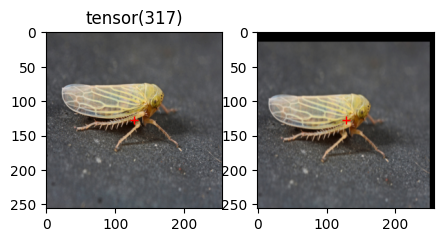

In [60]:
#theta = torch.cat((model.downscale.unsqueeze(0).repeat(
#            theta.size(0), 1, 1), theta.unsqueeze(2)),
#                          dim=2)
        
        #theta = theta.view(-1, 2, 3)
for num in range(50):
        plt.figure(figsize=(5,10))
        plt.subplot(1,2,1)
        img = data[0][num:num+1,...]   
        theta = output[1][num:num+1,...]
        #theta[0,:,2] = torch.FloatTensor((0,.5))
        print(theta[0,:,2].detach().numpy())
        grid_size = torch.Size([1, 3, 256, 256])
        grid = F.affine_grid(theta, grid_size)
        img_grid = F.grid_sample(img, grid)
        plt.imshow(data[0][num,...].permute(1,2,0).detach().numpy())
        plt.plot(127.5, 127.5, 'r+')
        plt.title(label[num])
        plt.subplot(1,2,2)
        plt.imshow(img_grid[0,:].permute(1,2,0).detach().numpy())
        plt.plot(127.5, 127.5, 'r+')
        plt.title(cat[num])

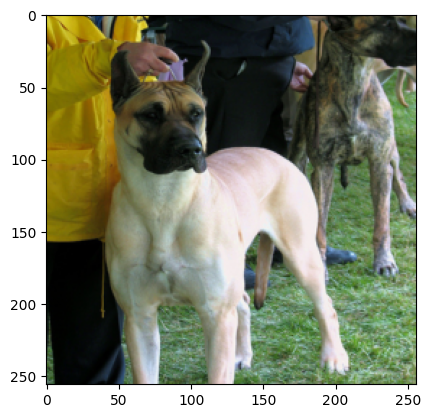

In [ ]:
plt.imshow(data[0][1,:].permute(1,2,0).detach().numpy())

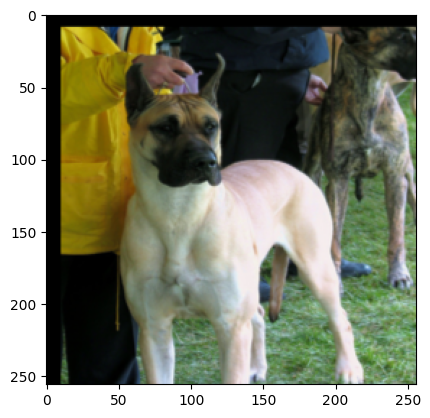

In [ ]:
plt.imshow(output[0][1,:].permute(1,2,0).detach().numpy())

In [ ]:
output[1][1][:,2].detach().numpy()

array([-0.08021453, -0.06861009])